In [7]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


from google.cloud import bigquery

import re
import nltk

from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk import ngrams, FreqDist

from unidecode import unidecode
from sklearn.feature_extraction import text
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise
import networkx as nx



# nltk.download('punkt')
# nltk.download('stopwords')

## BQ client setup

In [2]:
def estimate_bigquery_query_cost(bq_client, query):
    
    job_config = bigquery.QueryJobConfig()
    job_config.dry_run = True
    job_config.use_query_cache = False
    query_job = bq_client.query(

        (
           query
        ),
        job_config=job_config,
    )
    
    cost_euros = (query_job.total_bytes_processed / 1024 ** 4) * 6

    print(f"{query_job.total_bytes_processed} bytes will be processed , cost ~{cost_euros}$")

In [3]:
bigquery_client= bigquery.Client(project="ingka-chscesda-solar-dev") # ingka-energy-solar-dev # ingka-energy-analytics-dev

## Varaibles for query

In [4]:
date_min = "2022-07-16"

markets = tuple(['se', 'us',''])


# Get SQL string filter condition
product_string_queries = [
    'solar', 'sol', 'sun',
    'sunpower', 'svea', 
    'solstrale', 'SOLSTRÅLE', 
    'solpaneler', 'energy', 'electricity', 
]
string_exp = ' OR '.join([f'"{exp.lower()}" in UNNEST(internal_search_terms)' for exp in product_string_queries])
print(string_exp,'\n')

"solar" in UNNEST(internal_search_terms) OR "sol" in UNNEST(internal_search_terms) OR "sun" in UNNEST(internal_search_terms) OR "sunpower" in UNNEST(internal_search_terms) OR "svea" in UNNEST(internal_search_terms) OR "solstrale" in UNNEST(internal_search_terms) OR "solstråle" in UNNEST(internal_search_terms) OR "solpaneler" in UNNEST(internal_search_terms) OR "energy" in UNNEST(internal_search_terms) OR "electricity" in UNNEST(internal_search_terms) 



## Data mapping

#### Events, searches and pages 
(`ingka-web-analytics-prod.web_data_v2.hits_events_and_pages`): 
    - Landing on clean-energy (solar) tables, and session data
    - Searched string queries in the internal search bar
#### session data 
(`ingka-web-analytics-prod.web_data_v2.sessions`) - session data. Contains `icm_id`, `session_id` and `visitor_id`.

#### Customer data
- (`ikea-icm-prod.customer_master_golden_record_masked.v_cm_customer`) - Contains data on customer. *** waiting for access approval 
for info and access permissions *** 
- Alternatively - Use SCV **[single customer view](https://datacatalog.ingka.com/data/34/)** data for purchase history. Join `icm_id` key with hits events and pages. Start with [US data tables](https://datacatalog.ingka.com/schema/160/) until the Sweden data becomes available early August 2022.

Info on how to join session data to SCV (Jane Robinson):
```
Clickstream data is joined to our wider SCV dataset based on transaction ID or Sales Order Number (sono). 
We can then use the vistor ID assigned to these transactions to gather full browsing (and purchasing) history of this customer. 
If a customer has not purchased, we can use their ICM ID (when they are logged in) to gather full browsing history for that customer, 
conditional that the customer has made a transaction in store and they have an ICM ID. Currently, no clickstream data 
is surfaced in SCV KPI dashboards but is available to be used in the datasets
```

##### TODO:
- **Map google organic searches** (`ingka-do-seo-prod.integrated_search.gsc_est_revenue`) to IKEA user session activity. Attribution of organic searches, or grouping by user/session, is currently not possible
- Find **transactions data**, to see what visitors who reached CES goal have also bought (Use SCV?).



### Pages visited in sessions that included a landing in _any_ clean-energy page

In [16]:
# ### Page titles in sessions that included a landing in _any_ clean-energy page
# Visited pages
query_string = """
SELECT 
  pages.date_hit
  , pages.session_id
  , pages.page_titles
FROM (
  SELECT 
    date_hit
    -- , visitor_id
    , session_id
    , ARRAY_AGG(DISTINCT page_title) as page_titles
  FROM `ingka-web-analytics-prod.web_data_v2.hits_events_and_pages` 
  WHERE 
      date_hit >= "{date_hit}"
      AND website_market_short in {markets}
      AND event_category like '%page%'
      AND page_title is not NULL
  GROUP BY
      date_hit
      -- , visitor_id
      , session_id
) pages
INNER JOIN (
SELECT 
    DISTINCT session_id as session_id
FROM `ingka-web-analytics-prod.web_data_v2.hits_events_and_pages` 
WHERE 
    date_hit >= "{date_hit}"
    AND website_market_short in {markets}
    AND REGEXP_CONTAINS(page_url, ".+?clean-energy.+")
) cep
ON cep.session_id = pages.session_id
WHERE 
pages.date_hit >= "{date_hit}"
""".format(date_hit=date_min, markets=markets)
estimate_bigquery_query_cost(bigquery_client, query_string) 

148296025312 bytes will be processed , cost ~0.8092466958914883$


In [45]:
# Write to table
table_id="ingka-energy-analytics-dev.ces_da_playground.pages_temp"

job_config = bigquery.QueryJobConfig(
    allow_large_results=True, destination=table_id, use_legacy_sql=False,
    write_disposition = "WRITE_TRUNCATE"
)


bigquery_client.query(
    query_string, 
    job_config=job_config
).result()

In [55]:
# Results to pandas df
job_config = bigquery.QueryJobConfig(
    use_legacy_sql=False
)

df = (
    bigquery_client.query(query_string, job_config)
    .result()
    .to_dataframe(
        # Optionally, explicitly request to use the BigQuery Storage API. As of
        # google-cloud-bigquery version 1.26.0 and above, the BigQuery Storage
        # API is used by default.
        create_bqstorage_client=True,
    )
)

df

## Clustering analysis

1. **Clean:** Parse page titles into keywords (or n-grams?), tokenize, stem, remove stopwords.
2. **Vectorize:** Count keywords co-occurences on session level, put pairs/ngrams into adjacency matrix.
3. Calculate **cos-similarity** between vectors.
4. **Cluster** (kmeans, dbscan, hdbscan)


In [5]:
# Read results from BQ

query_string = """
    SELECT * FROM ingka-energy-analytics-dev.ces_da_playground.pages_temp
"""

job_config = bigquery.QueryJobConfig(
    use_legacy_sql=False
)

df = (
    bigquery_client.query(query_string, job_config)
    .result()
    .to_dataframe(
        # Optionally, explicitly request to use the BigQuery Storage API. As of
        # google-cloud-bigquery version 1.26.0 and above, the BigQuery Storage
        # API is used by default.
        create_bqstorage_client=True,
    )
)

# Read results from CSV
# PATH = '~/Downloads/bquxjob_3de0e649_182114894b2.csv'
# df = pd.read_csv(PATH)
df.head()

,date_hit,session_id,page_titles
0,2022-07-16,26646566948822689411657992984,"[el - Sök - IKEA, solceller - Sök - IKEA]"
1,2022-07-16,61359967784544557581657973979,"[Högtalare - IKEA, Smarta hem system & styrenh..."
2,2022-07-17,84562843468019643631658045771,[Smarta hem - IKEA]
3,2022-07-17,10127046967948579791658044923,"[Smarta hem - IKEA, LED-belysning för hela hem..."
4,2022-07-17,12472088288234791811658061160,"[Smarta hem - IKEA, Smarta och elektriska rull..."


In [8]:
stop_en = set(stopwords.words('english'))
stop_se = set(stopwords.words('swedish'))
stop_se = set([unidecode(sw, "utf-8") for sw in stop_se])

stop_words = stop_se | stop_en
stop_words.update(['ikea', 'sok', "mer",
                   '-', '&', " ,", ",", "``", "/", 
                   "x", "xx", "search", "cm", 
                   "white", "vit", "svart", "black", 
                   "sektion"
                  ])
# stop_words

stemmer = SnowballStemmer("swedish")

In [9]:

df['pt_std'] = df.page_titles.apply(
    # Convert to utf8, lower case and filter out numbers
    lambda x: [
        re.sub(r'\d+|\`', '', unidecode(w.lower(), "utf-8")) for w in set(x) 
    ]
)
df['pt_tokens'] = df.pt_std.apply(
    # Tokenize
    lambda x: [
        nltk.tokenize.word_tokenize(w) for w in set(x)
    ]
)
df['doc'] = df.pt_tokens.apply(
    # Stem and remove stop words
    lambda x: " ".join([
        stemmer.stem(w) for title in x for w in title if w not in stop_words
    ])
)
df.head(10)

,date_hit,session_id,page_titles,pt_std,pt_tokens,doc
0,2022-07-16,26646566948822689411657992984,"[el - Sök - IKEA, solceller - Sök - IKEA]","[solceller - sok - ikea, el - sok - ikea]","[[el, -, sok, -, ikea], [solceller, -, sok, -,...",el solcell
1,2022-07-16,61359967784544557581657973979,"[Högtalare - IKEA, Smarta hem system & styrenh...","[smarta och elektriska rullgardiner - ikea, sm...","[[smarta, och, elektriska, rullgardiner, -, ik...",smart elektrisk rullgardin rullgardin morklagg...
2,2022-07-17,84562843468019643631658045771,[Smarta hem - IKEA],[smarta hem - ikea],"[[smarta, hem, -, ikea]]",smart hem
3,2022-07-17,10127046967948579791658044923,"[Smarta hem - IKEA, LED-belysning för hela hem...","[ryet led ljuskalla g lumen, opalvit - ikea, ...","[[sillbo, led, ljuskalla, e, lumen, ,, globfor...",sillbo led ljuskall e lum globform toppforspeg...
4,2022-07-17,12472088288234791811658061160,"[Smarta hem - IKEA, Smarta och elektriska rull...","[smarta och elektriska rullgardiner - ikea, sm...","[[smarta, och, elektriska, rullgardiner, -, ik...",smart elektrisk rullgardin solcell paket pris ...
5,2022-07-17,68991779397134171971658085356,"[Smarta hem - IKEA, Solceller – paket och pris...","[vindriktning luftkvalitetsmatare - ikea, solc...","[[solceller, -, paket, och, priser, for, din, ...",solcell paket pris vill tak smart hem smart he...
6,2022-07-16,1019841633098230381658002370,[64791 - Sök - IKEA],[ - sok - ikea],"[[-, sok, -, ikea]]",
7,2022-07-17,64536940361676008951658039039,[81892 - Sök - IKEA],[ - sok - ikea],"[[-, sok, -, ikea]]",
8,2022-07-16,22714134062706553741657965453,"[Billy - Sök - IKEA, BILLY Bokhylla med glasdö...","[billy - sok - ikea, billy bokhylla med glasdo...","[[billy, -, sok, -, ikea], [billy, bokhylla, m...",billy billy bokhyll glasdorr gra metallikeffek
9,2022-07-17,33718153678820597471658085014,[456 55 - Sök - IKEA],[ - sok - ikea],"[[-, sok, -, ikea]]",


In [10]:
df['page_titles'][5]

array(['Smarta hem - IKEA',
       'Solceller – paket och priser för din villa och tak - IKEA',
       'VINDRIKTNING Luftkvalitetsmätare - IKEA',
       'Smarta hem system & styrenheter - IKEA'], dtype=object)

In [11]:
# Vectorizing 
# Using bag of words
vectorizer_cv = text.TfidfVectorizer(analyzer='word', ngram_range=(1, 2))
X_cv = vectorizer_cv.fit_transform(df.doc).toarray()
vectorizer_cv.get_feature_names_out()

array(['acaci', 'acaci kullaberg', 'accent', ..., 'zon', 'zon svart',
       'zon vagghang'], dtype=object)

In [12]:
bow_mat = pd.concat([df.doc,pd.DataFrame(vectorizer_cv.fit_transform(df.doc).toarray(), columns = vectorizer_cv.get_feature_names_out())], axis=1)
bow_mat.head()

,doc,acaci,acaci kullaberg,accent,accent decorating,accessori,accessori haug,accessori kid,accessori offic,accessori organizer,...,xx kitch,ypper,ypper led,yta,yta antracit,yuppienall,yuppienall hall,zon,zon svart,zon vagghang
0,el solcell,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,smart elektrisk rullgardin rullgardin morklagg...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,smart hem,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,sillbo led ljuskall e lum globform toppforspeg...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,smart elektrisk rullgardin solcell paket pris ...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
# Calculate cosine similarity !!!

# coss_mat = np.dot(X_cv, X_cv.T) # / (np.linalg.norm(X_cv) * np.linalg.norm(X_cv))
X_cv_cs = pairwise.cosine_similarity(X_cv)
np.fill_diagonal(X_cv_cs, 0)
X_cv_cs

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.04185812],
       [0.        , 0.        , 0.28005581, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.28005581, 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.04185812, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [14]:
bow_mat.doc.iloc[220:230,]

220      solcell paket pris vill tak elavtal el sol vind
221    skruv memo board wifi password eco-friendly fu...
222                   smart belysning lamp styr app wifi
223    silcell lamp utebelysning sling tradgard altan...
224    gallery kitch inspiration kitch servic kitch p...
225    hemn daybed drawers/ mattress gray/vannareid m...
226    co-worker shar clev ide hom innovativ ide hom ...
227                           fridan morklagg rullgardin
228    skriv garderob mobl kop mobl varuhus onlin skr...
229    smart belysning lamp styr app wifi komplement ...
Name: doc, dtype: object

In [15]:
print(f"{bow_mat.loc[5, ['doc']].values} \n<-->\n{bow_mat.loc[4, ['doc']].values}")

['solcell paket pris vill tak smart hem smart hem system styren vindriktning luftkvalitetsmat'] 
<-->
['smart elektrisk rullgardin solcell paket pris vill tak smart belysning lamp styr app wifi smart hem skurup taksken -spot smart lamp']


In [16]:
# Cluster kmeans
kmeans = KMeans(n_clusters=7, random_state=0).fit(X_cv_cs)
kmeans.labels_

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 1, 3, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       1, 1, 1, 1, 1, 0, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       2, 2, 2, 1, 0, 0, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3,
       3, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

In [17]:
top_words_dict = {}
for i in range(kmeans.n_clusters):
    tokens = nltk.tokenize.word_tokenize(" ".join(df.loc[(kmeans.labels_ == i), 'doc']))
    fdist = FreqDist(ngrams(tokens, 1))
    words_count = {k[0]:v for k,v in sorted(fdist.items(), key=lambda item: item[1], reverse=True)[:10:]}
    print(words_count)
    top_words_str = " ".join([k for k in words_count][:5])
    top_words_dict[i] = top_words_str
top_words_dict

{'kitch': 217, 'inspiration': 53, 'gallery': 42, 'cabinet': 29, 'applianc': 22, 'upgr': 21, 'mod': 19, '``': 18, 'door': 17, 'ide': 16}
{'``': 101, 'kitch': 80, 'smart': 73, 'cabinet': 46, 'belysning': 38, 'inspiration': 36, 'storag': 36, 'lamp': 30, 'hemmet': 27, 'ide': 27}
{'solcell': 35}
{'solcell': 28, 'paket': 27, 'pris': 27, 'vill': 27, 'tak': 27, 'elavtal': 4, 'el': 4, 'sol': 4, 'vind': 4, 'smart': 1}
{'elavtal': 18, 'el': 18, 'sol': 18, 'vind': 18}
{'energitjanst': 15}
{'solpanel': 17, 'solcell': 3, 'energitjanst': 1}


{0: 'kitch inspiration gallery cabinet applianc',
 1: '`` kitch smart cabinet belysning',
 2: 'solcell',
 3: 'solcell paket pris vill tak',
 4: 'elavtal el sol vind',
 5: 'energitjanst',
 6: 'solpanel solcell energitjanst'}

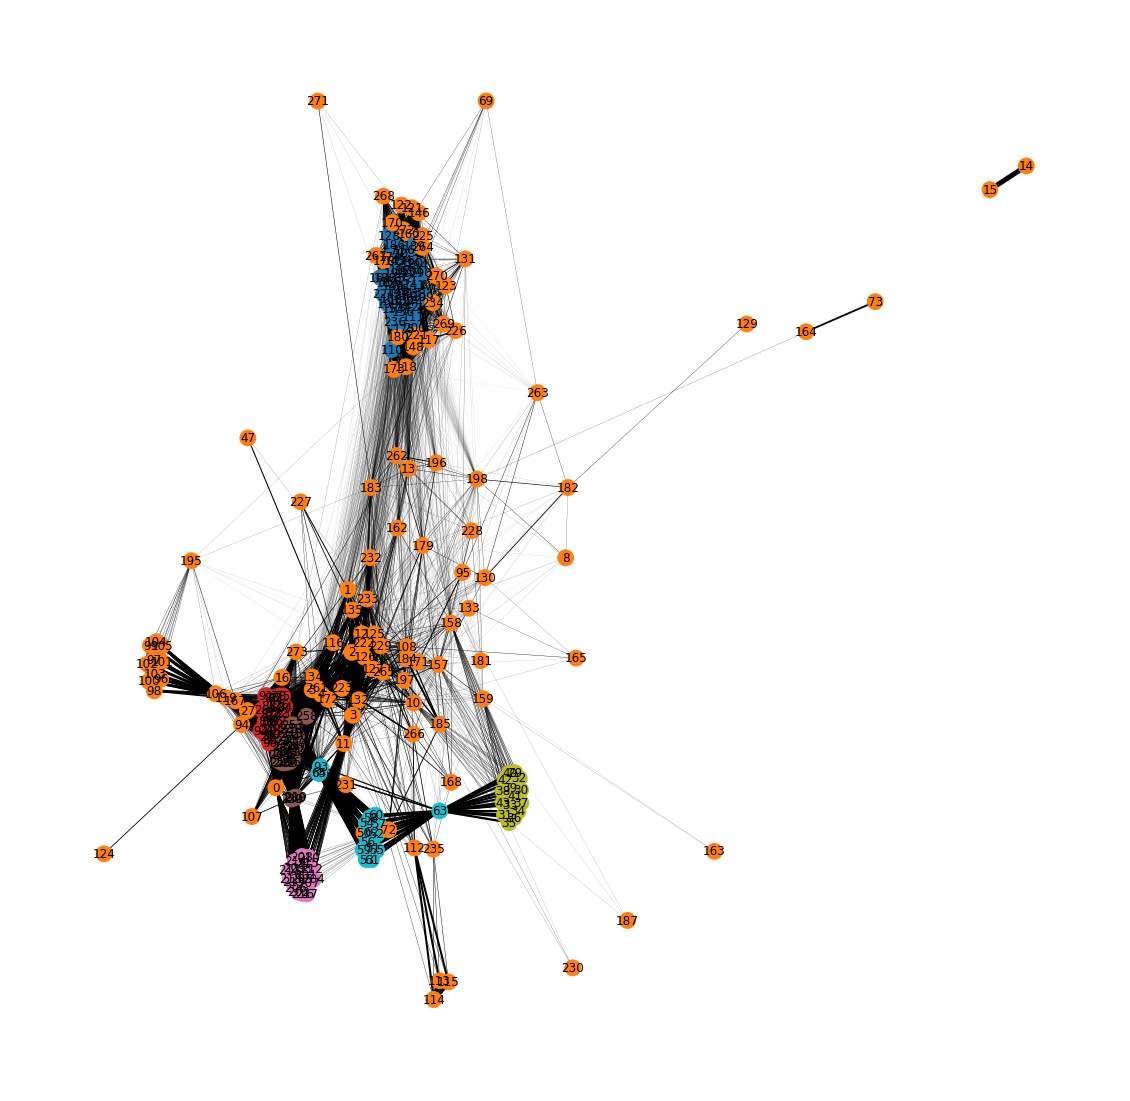

In [98]:
# Draw clusters
G = nx.from_pandas_adjacency(pd.DataFrame(X_cv_cs))

# Remove isolated nodes for easier drawing
isolates = list(nx.isolates(G))
G.remove_nodes_from(isolates)
kmlabels = list(kmeans.labels_)
[kmlabels.pop(i) for i in isolates]

fig, ax = plt.subplots(figsize=(20,20))
nx.draw(G, 
        pos=nx.spring_layout(G),
        node_size=250, 
        width = [5*w for w in nx.get_edge_attributes(G, 'weight').values()],
        node_color = kmlabels,
        cmap=plt.get_cmap('tab10'),
        with_labels=True, 
        ax=ax
       )

In [19]:
from sklearn.cluster import DBSCAN

cl_dbs = DBSCAN(
    eps=.25, 
    min_samples=2
).fit(X_cv_cs)
cl_dbs.labels_

array([-1, -1, -1, -1, -1, -1,  0,  0,  0,  0, -1, -1, -1,  1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  0,  0,  0,  0,  0, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1,  0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1,  0, -1, -1, -1, -1,  0,  0, -1, -1,  0, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1,  0,  0, -1, -1, -1,  0, -1,  0, -1, -1,  0, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  0,  0, -1, -1, -1, -1,
        0, -1, -1, -1, -1, -1, -1, -1,  0,  0, -1,  0, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1

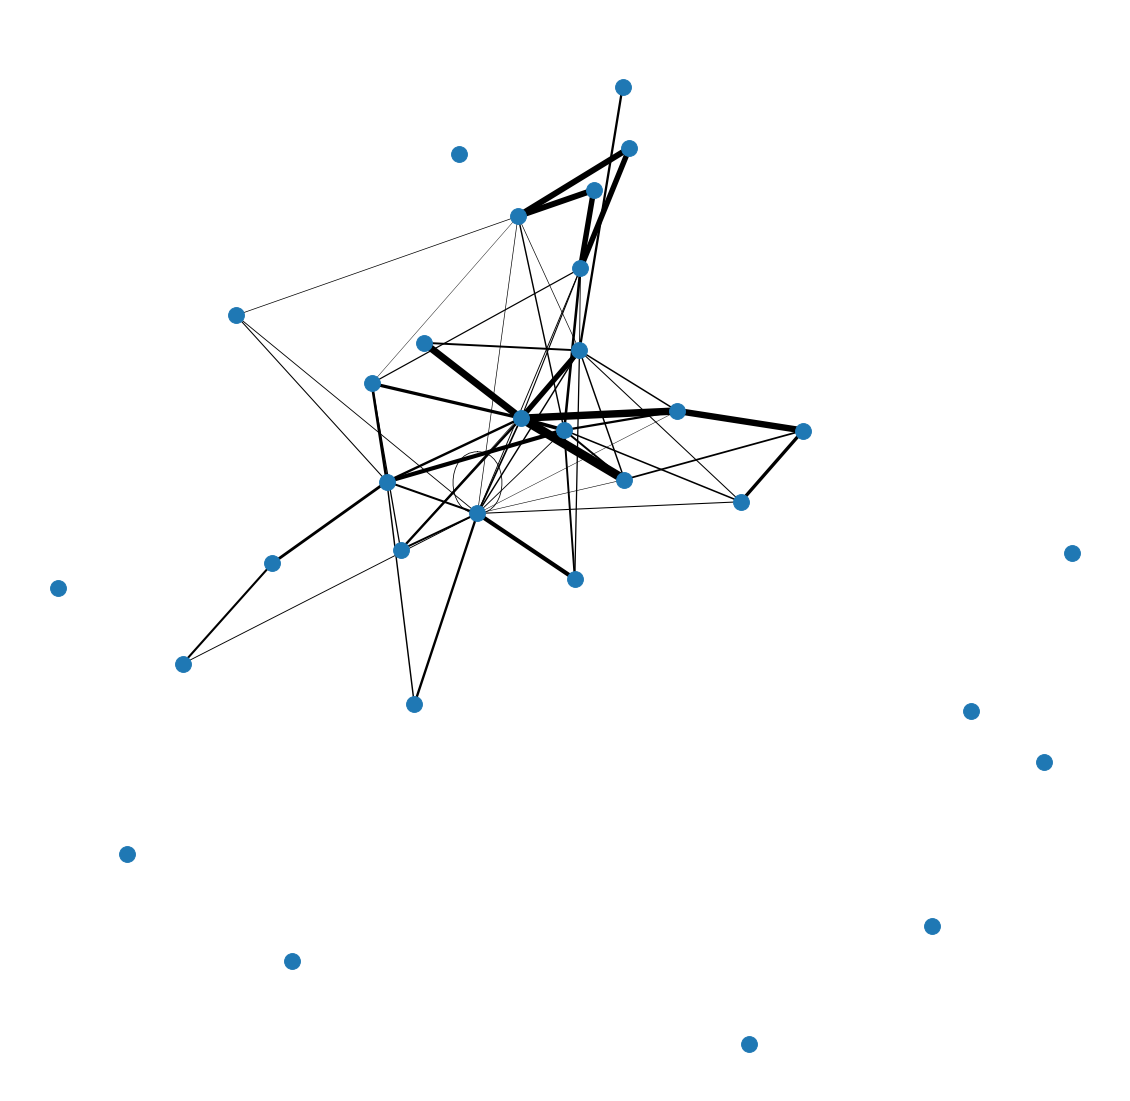

In [45]:
top_words_dict = {}
for i in range(0, len(set(cl_dbs.labels_))-1):
    tokens = nltk.tokenize.word_tokenize(" ".join(df.loc[(cl_dbs.labels_ == i), 'doc']))
    fdist = FreqDist(ngrams(tokens, 1))
    words_count = {k[0]:v for k,v in sorted(fdist.items(), key=lambda item: item[1], reverse=True)[:10:]}
    top_words_str = " ".join([k for k in words_count][:5])
    top_words_dict[i] = top_words_str
top_words_dict


# Draw clusters
G = nx.from_pandas_adjacency(pd.DataFrame(
    X_cv_cs[cl_dbs.labels_ == 0]
))

fig, ax = plt.subplots(figsize=(20,20))
nx.draw(G, 
        pos=nx.spring_layout(G),
        node_size=250, 
        width = [100*w for w in nx.get_edge_attributes(G, 'weight').values()],
#         node_color = cl_dbs.labels_,
        cmap=plt.get_cmap('tab10'),
#         labels=df.doc.apply(lambda x: x[:15]), 
#         with_labels=True, 
        ax=ax
       )

In [105]:
import hdbscan

# https://hdbscan.readthedocs.io/en/0.8.4/api.html

cl_hdbs = hdbscan.HDBSCAN(
    min_samples = 3, 
    min_cluster_size = 3,
    gen_min_span_tree = False,
)
cl_hdbs.fit(X_cv_cs)
cl_hdbs.labels_

array([-1, -1, -1, -1,  9,  9, 10, 10, 10, 10, 10, -1, -1, 10, -1, -1,  7,
        4,  4,  4,  4,  4,  4,  4,  4,  4,  7, -1,  5,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2, 10, 10, 10, 10, 10, -1,  3,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3, -1, -1, -1,  4,  4,
        4, 10, -1, -1, 10, 10,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
        4,  4,  4,  4,  4,  4,  7,  7, -1, 10, 10,  6,  6,  6,  6,  6,  6,
        6,  6,  6,  6, -1, 10, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 11,
       -1, -1, -1, 11, 10, 10, -1, -1, -1, -1, 10, 10, 10, -1, 10,  9, -1,
        8,  8,  8,  8,  8,  8,  8,  8,  8, -1, 11, -1, 11, -1, -1, -1, -1,
       -1, -1, -1, -1, 10, 10, 10, -1, -1, 10, 10, 10, 10, -1, 10, 10, -1,
       11, -1,  9, 10, -1, -1, -1, -1, 11, 10, 11, 10, 10, 10, -1, -1, -1,
       10, -1, -1, -1, -1, -1, -1, -1, 10, 10, -1, 10, -1, -1,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,
       11, -1, -1, -1, 11

In [106]:
bow_mat[cl_hdbs.labels_ == 7]['doc']

16    produk solcell solcell
26           solcell solcell
91           solcell solcell
92           solcell solcell
Name: doc, dtype: object

In [107]:
top_words_dict = {}
for i in range(0, len(set(cl_hdbs.labels_))-1):
    tokens = nltk.tokenize.word_tokenize(" ".join(df.loc[(cl_hdbs.labels_ == i), 'doc']))
    fdist = FreqDist(ngrams(tokens, 1))
    words_count = {k[0]:v for k,v in sorted(fdist.items(), key=lambda item: item[1], reverse=True)[:10:]}
    top_words_str = " ".join([k for k in words_count][:5])
    top_words_dict[i] = top_words_str
top_words_dict

{0: 'elavtal el sol vind',
 1: 'solcell paket pris vill tak',
 2: 'energitjanst',
 3: 'solpanel',
 4: 'solcell',
 5: 'solcell paket pris vill tak',
 6: 'solstral',
 7: 'solcell produk',
 8: 'gallery kitch inspiration',
 9: 'smart hem solcell paket pris',
 10: '`` sof /x/ ide inspiration',
 11: 'kitch `` cabinet gallery inspiration'}

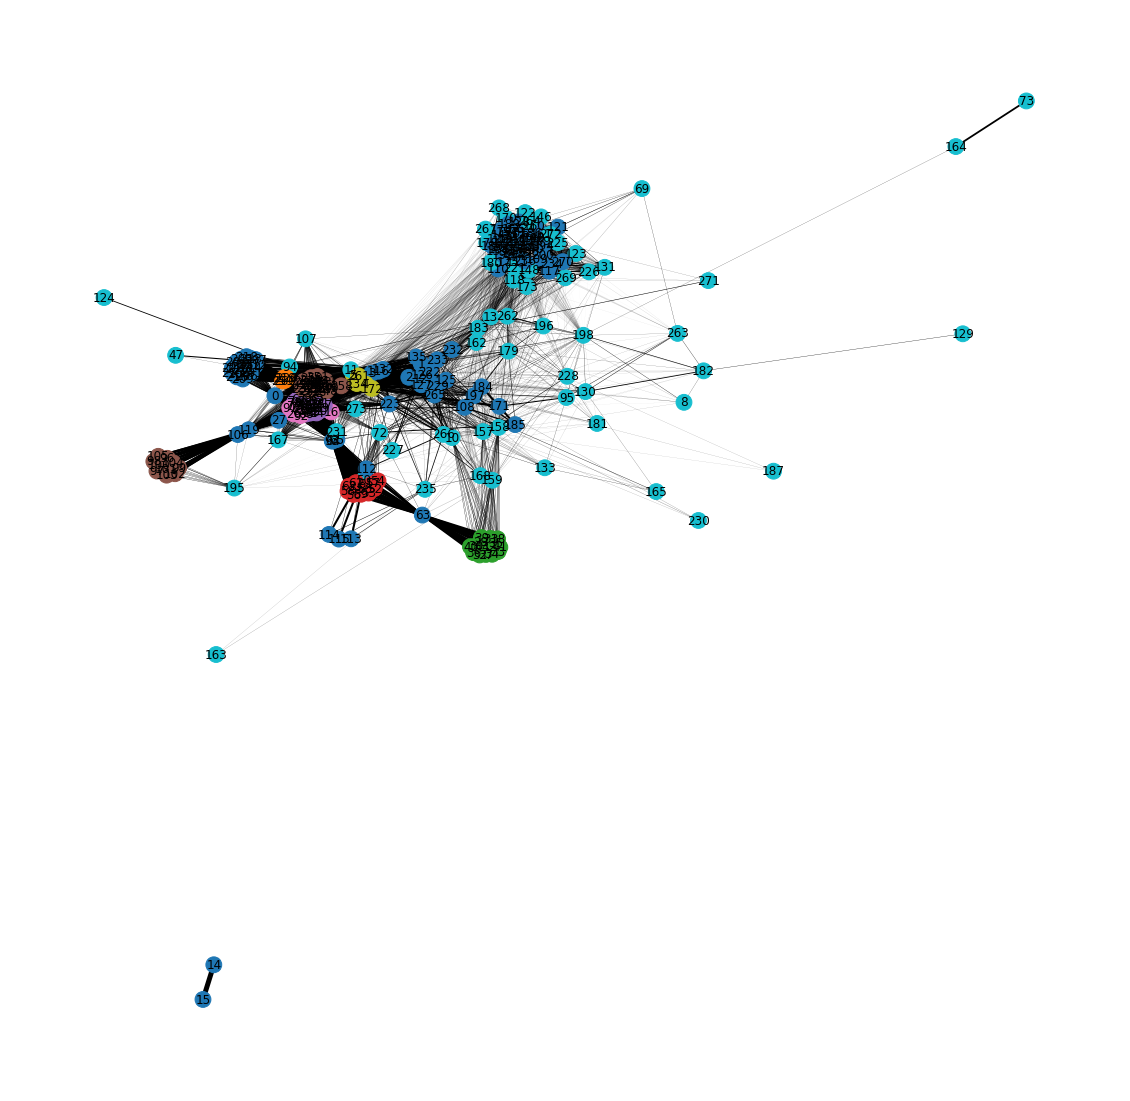

In [108]:
# Draw clusters
G = nx.from_pandas_adjacency(pd.DataFrame(X_cv_cs))

# Remove isolated nodes for easier drawing
isolates = list(nx.isolates(G))
G.remove_nodes_from(isolates)
labels = list(cl_hdbs.labels_)
[labels.pop(i) for i in isolates]

fig, ax = plt.subplots(figsize=(20,20))
nx.draw(G, 
        pos=nx.spring_layout(G),
        node_size=250, 
        width = [5*w for w in nx.get_edge_attributes(G, 'weight').values()],
        node_color = labels,
        cmap=plt.get_cmap('tab10'),
        with_labels=True, 
        ax=ax
       )

/opt/homebrew/lib/python3.9/site-packages/hdbscan/plots.py:383: UserWarning: Infinite lambda values encountered in chosen clusters. This might be due to duplicates in the data.
  warn('Infinite lambda values encountered in chosen clusters.'


<AxesSubplot:ylabel='$\\lambda$ value'>

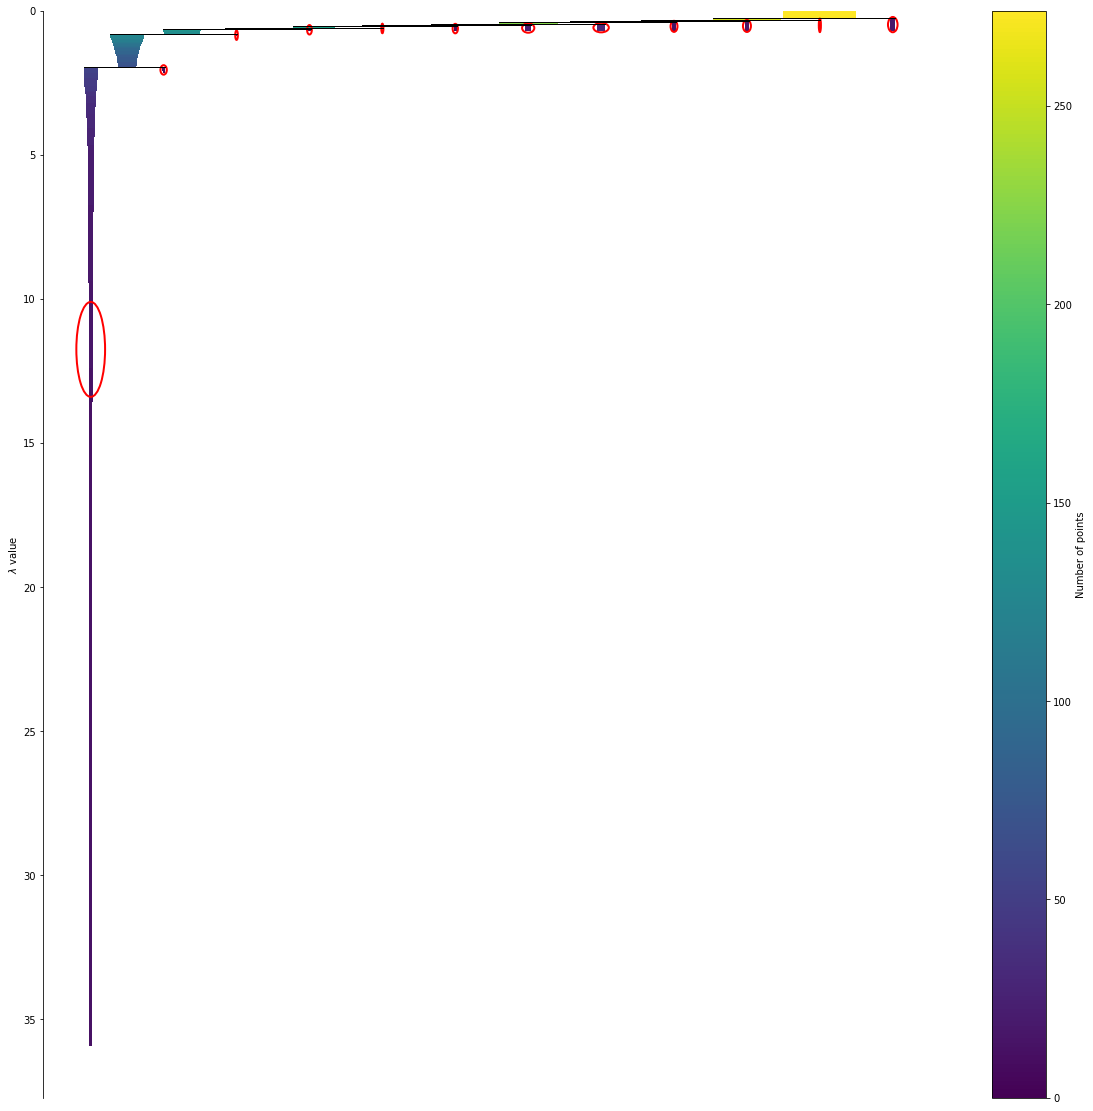

In [109]:
fig, ax = plt.subplots(figsize=(20,20))
cl_hdbs.condensed_tree_.plot(select_clusters=True, selection_palette=sns.color_palette())
